In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 1. 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리

In [2]:
df = pd.read_csv('../data/Sleep_health_and_lifestyle_dataset.csv')

In [3]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
df['BMI Category'].unique()

array(['Overweight', 'Normal', 'Obese', 'Normal Weight'], dtype=object)

## Normal Weight와 Normal 합치기

In [5]:
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

In [6]:
df['BMI Category'].unique()

array(['Overweight', 'Normal', 'Obese'], dtype=object)

In [7]:
df['Sleep Disorder'].unique()

array([nan, 'Sleep Apnea', 'Insomnia'], dtype=object)

## 직업 대분류로 나누기

In [8]:
df['Occupation'].unique()

array(['Software Engineer', 'Doctor', 'Sales Representative', 'Teacher',
       'Nurse', 'Engineer', 'Accountant', 'Scientist', 'Lawyer',
       'Salesperson', 'Manager'], dtype=object)

## Blood Pressure 나누기

In [9]:
# Blood Pressure 분리
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True)

# 정수형으로 변환
df['Systolic'] = df['Systolic'].astype(int)
df['Diastolic'] = df['Diastolic'].astype(int)

# 필요하다면 원래 'Blood Pressure' 컬럼 제거
df.drop('Blood Pressure', axis=1, inplace=True)

## 카테고리컬로 string 없애기

Fmale : 0
Male  : 1

None        : 0
Insomnia    : 1



In [10]:
# 1. 수동 인코딩
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')
df['Sleep Disorder'] = df['Sleep Disorder'].map({
    'None': 0,
    'Insomnia': 1,
})

# 2. 자동 인코딩 (남은 object형 변수)
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le


In [11]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,1,1,27,9,6.1,6,42,6,2,77,4200,0.0,126,83
1,2,1,28,1,6.2,6,60,8,0,75,10000,0.0,125,80
2,3,1,28,1,6.2,6,60,8,0,75,10000,0.0,125,80
3,4,1,28,6,5.9,4,30,8,1,85,3000,NaN,140,90
4,5,1,28,6,5.9,4,30,8,1,85,3000,NaN,140,90


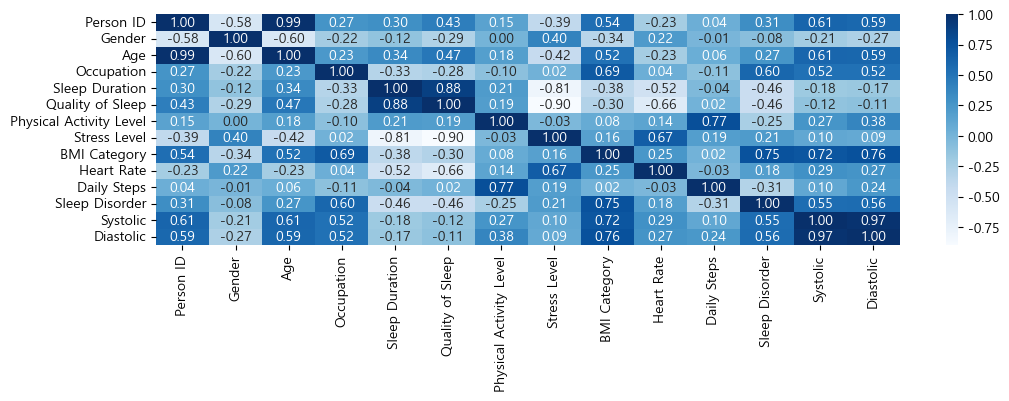

In [12]:
df.corr()

# 상관계수 테이블 만들기
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,3))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="Blues")
plt.show()

## 상관계수 낮은 데이터 지우기

In [13]:
df.drop(['Person ID', 'Daily Steps', 'Sleep Disorder', 'Sleep Duration'], axis=1, inplace=True)

In [14]:
print(df.columns)

Index(['Gender', 'Age', 'Occupation', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Systolic', 'Diastolic'],
      dtype='object')


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Gender                   374 non-null    int64
 1   Age                      374 non-null    int64
 2   Occupation               374 non-null    int64
 3   Quality of Sleep         374 non-null    int64
 4   Physical Activity Level  374 non-null    int64
 5   Stress Level             374 non-null    int64
 6   BMI Category             374 non-null    int64
 7   Heart Rate               374 non-null    int64
 8   Systolic                 374 non-null    int64
 9   Diastolic                374 non-null    int64
dtypes: int64(10)
memory usage: 29.3 KB


## 학습 데이터 / 타겟 데이터 나누기

In [16]:
# Quality of Sleep을 예측할 때
from sklearn.model_selection import train_test_split

X = df.drop(['Quality of Sleep'], axis=1)
y = df['Quality of Sleep']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🔁 gubun 재설정 (핵심!)
df['gubun'] = 'train'
df.loc[X_test.index, 'gubun'] = 'test'

## 이상치 제거

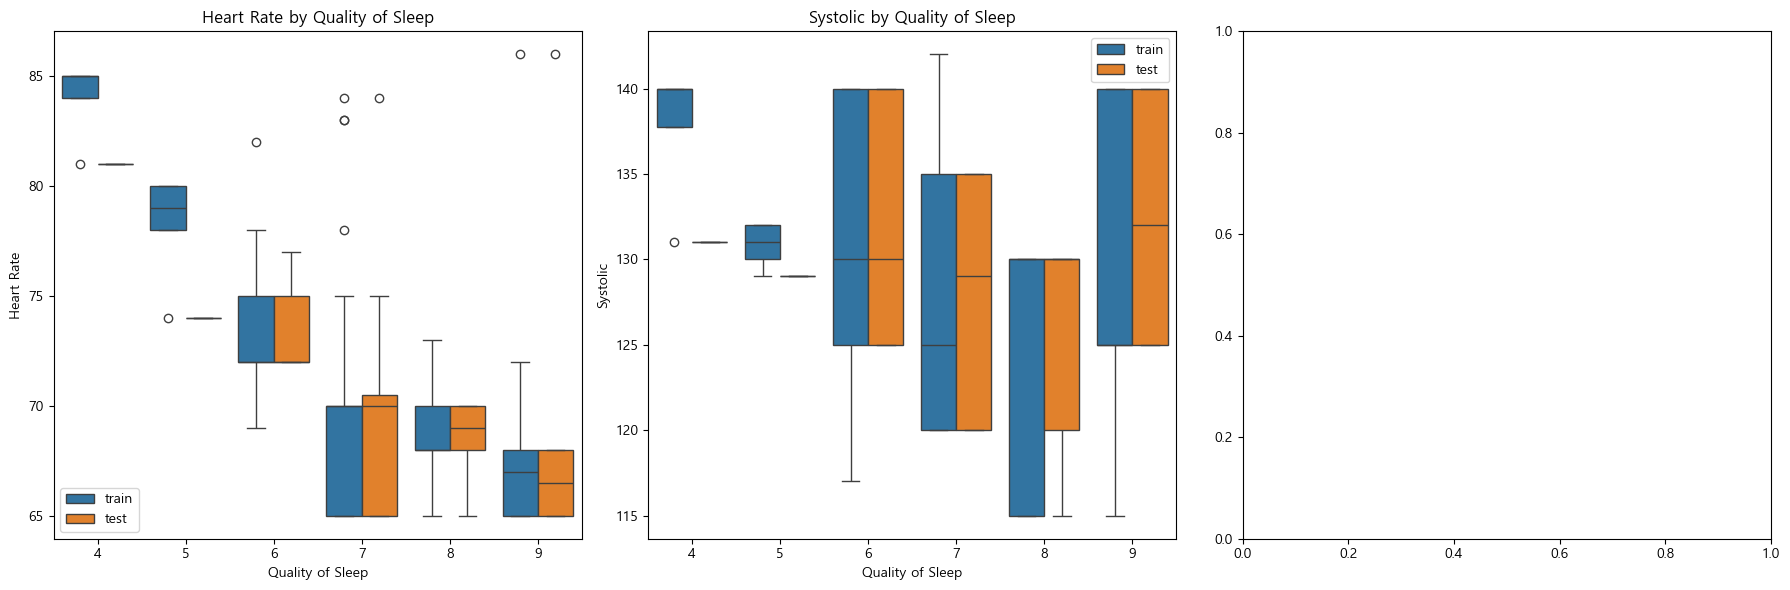

In [17]:
cols = ['Heart Rate', 'Systolic']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1행 3열

for i, col in enumerate(cols):
    sns.boxplot(x="Quality of Sleep", y=col, data=df, hue='gubun', ax=axes[i])
    axes[i].set_title(f"{col} by Quality of Sleep")
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()

In [18]:
# 이상치 제거 조건 수동 정의
condition = (
    (df['Heart Rate'].between(60, 90)) &
    (df['Systolic'].between(110, 140))
)

df_clean = df[condition].copy()

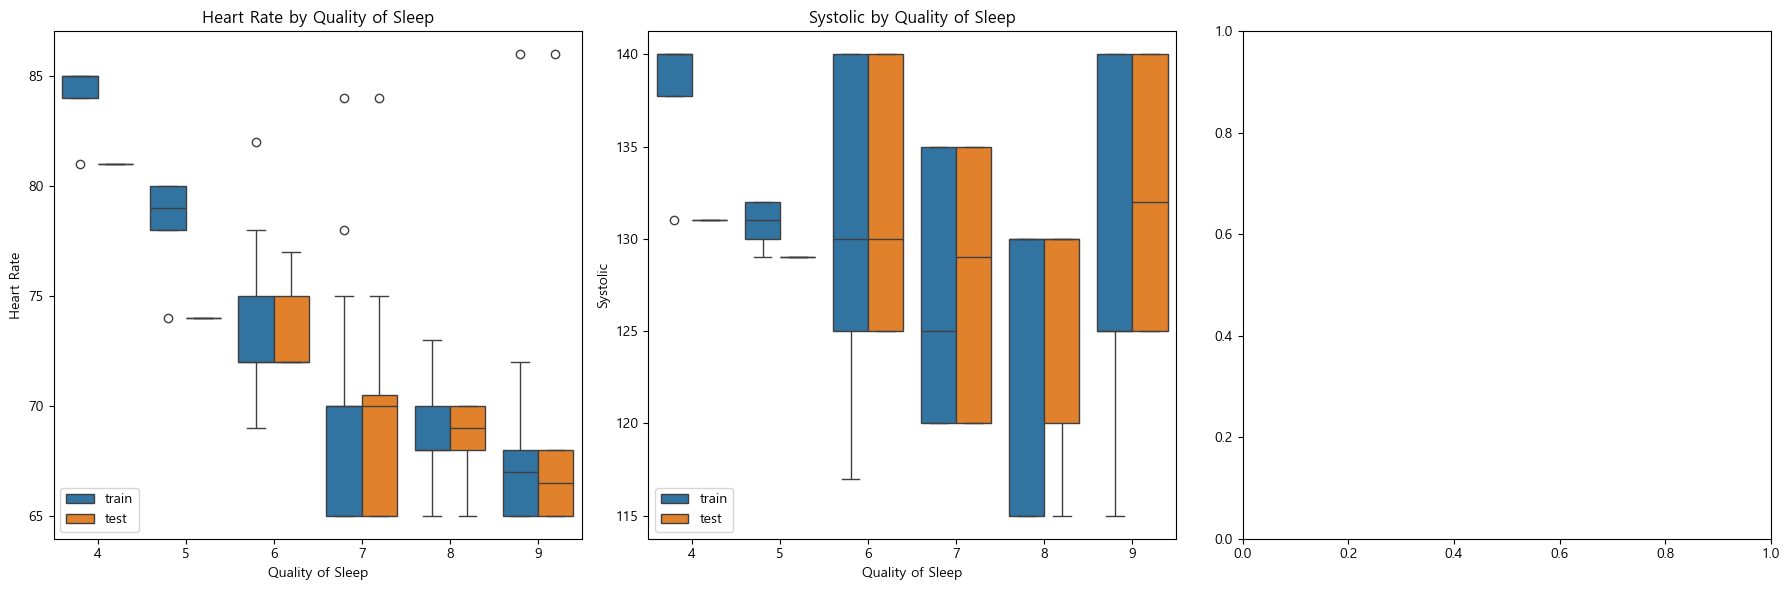

In [19]:
cols = ['Heart Rate', 'Systolic']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1행 3열

for i, col in enumerate(cols):
    sns.boxplot(x="Quality of Sleep", y=col, data=df_clean, hue='gubun', ax=axes[i])
    axes[i].set_title(f"{col} by Quality of Sleep")
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()


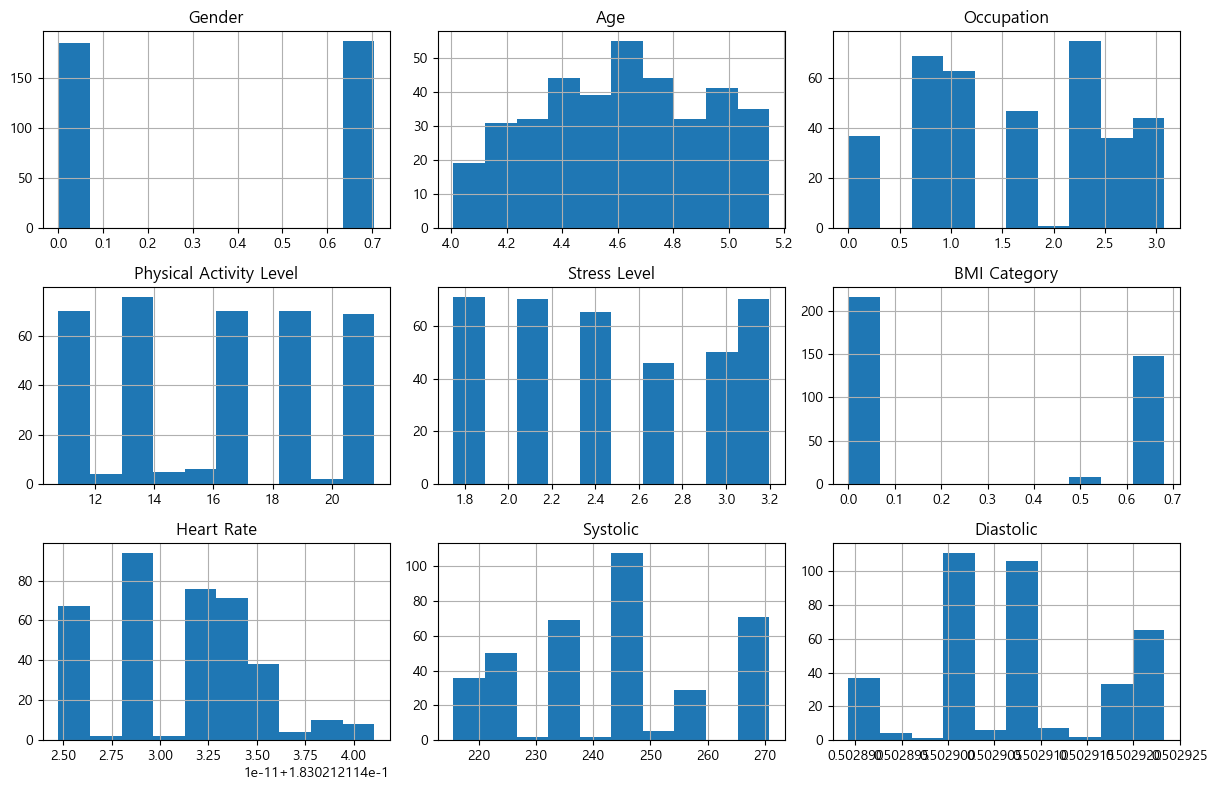

In [20]:
from scipy.stats import boxcox

# X, y 분리
X = df_clean.drop(['Quality of Sleep', 'gubun'], axis=1)
y = df_clean['Quality of Sleep']

# 수치형 컬럼만 선택
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# boxcox 적용
for col in numeric_cols:
    X[col], _ = boxcox(X[col] + 1)  # +1: 0이나 음수 방지

# 히스토그램 확인
X.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# 모델 학습

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
# 1. 모델 학습
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# 2. 예측
y_pred = rf_model.predict(X_test)

In [24]:
# 3. 평가
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.95      1.00      0.98        21
           7       1.00      0.94      0.97        16
           8       1.00      0.91      0.95        22
           9       0.88      1.00      0.93        14

    accuracy                           0.96        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.96      0.96      0.96        75


Confusion Matrix:
[[ 1  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0 21  0  0  0]
 [ 0  0  1 15  0  0]
 [ 0  0  0  0 20  2]
 [ 0  0  0  0  0 14]]


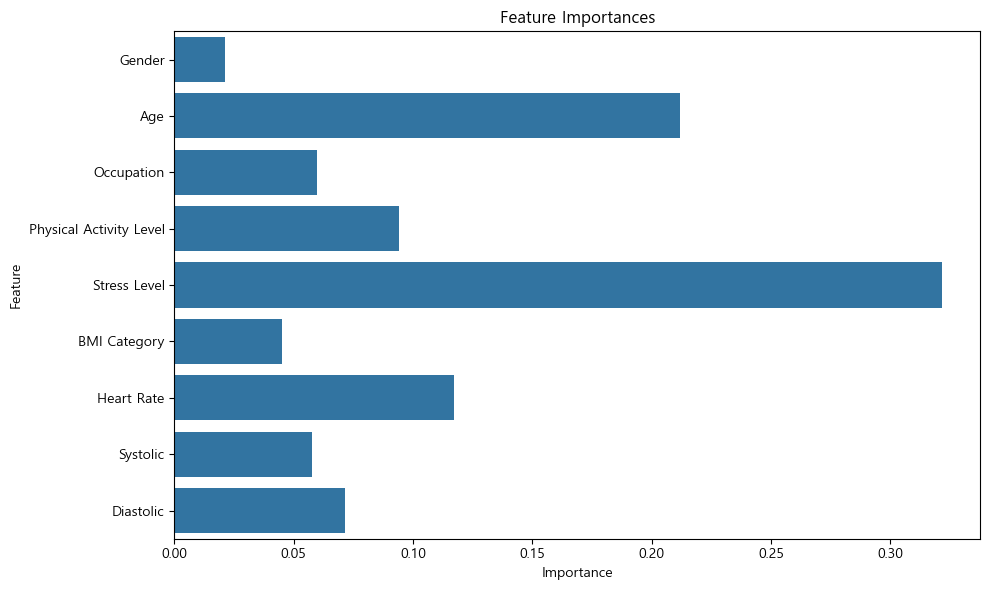

In [25]:
# 4. 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
features = X_train.columns  # X가 아니라 X_train이 더 안전

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 군집

In [26]:
X_cluster = df.drop(columns=['Quality of Sleep', 'gubun'])  # 타겟/인덱스 제거

In [27]:
X_cluster.head()

,Gender,Age,Occupation,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Systolic,Diastolic
0,1,27,9,42,6,2,77,126,83
1,1,28,1,60,8,0,75,125,80
2,1,28,1,60,8,0,75,125,80
3,1,28,6,30,8,1,85,140,90
4,1,28,6,30,8,1,85,140,90


In [28]:
from sklearn.cluster import KMeans
import pandas as pd

# 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
X_cluster['Cluster'] = kmeans.fit_predict(X_cluster)

# ✔ 방법 1. 범주형 컬럼들의 최빈값(mode) 보기
cluster_mode = X_cluster.groupby('Cluster').agg(lambda x: x.mode().iloc[0])

# ✔ 방법 2. 범주형 변수의 비율 분석 예시 (선택)
# 범주형 변수들만 골라서 비율로 출력
cat_cols = X_cluster.columns  # X_cluster가 이미 LabelEncoding 등으로 수치화된 범주형 데이터라고 가정
for col in cat_cols:
    print(f'\n[📊 {col} 비율 분포]')
    print(pd.crosstab(X_cluster['Cluster'], X_cluster[col], normalize='index'))

# ✔ 최빈값 테이블 확인
pd.set_option('display.max_columns', None)
display(cluster_mode)


[📊 Gender 비율 분포]
Gender          0         1
Cluster                    
0        0.500000  0.500000
1        0.644231  0.355769
2        0.353448  0.646552

[📊 Age 비율 분포]
Age            27        28        29        30        31        32        33  \
Cluster                                                                         
0        0.006494  0.019481  0.058442  0.012987  0.019481  0.084416  0.084416   
1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2        0.000000  0.017241  0.034483  0.094828  0.129310  0.034483  0.000000   

Age            34        35        36  ...        50        51        52  \
Cluster                                ...                                 
0        0.012987  0.012987  0.012987  ...  0.006494  0.025974  0.058442   
1        0.000000  0.000000  0.000000  ...  0.182692  0.028846  0.000000   
2        0.000000  0.086207  0.086207  ...  0.000000  0.008621  0.000000   

Age           53        54        55    

,Gender,Age,Occupation,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Systolic,Diastolic
Cluster,,,,,,,,,
0,0,44,2,30,7,2,72,125,80
1,0,50,5,90,3,2,68,140,95
2,1,38,1,60,4,0,68,120,80


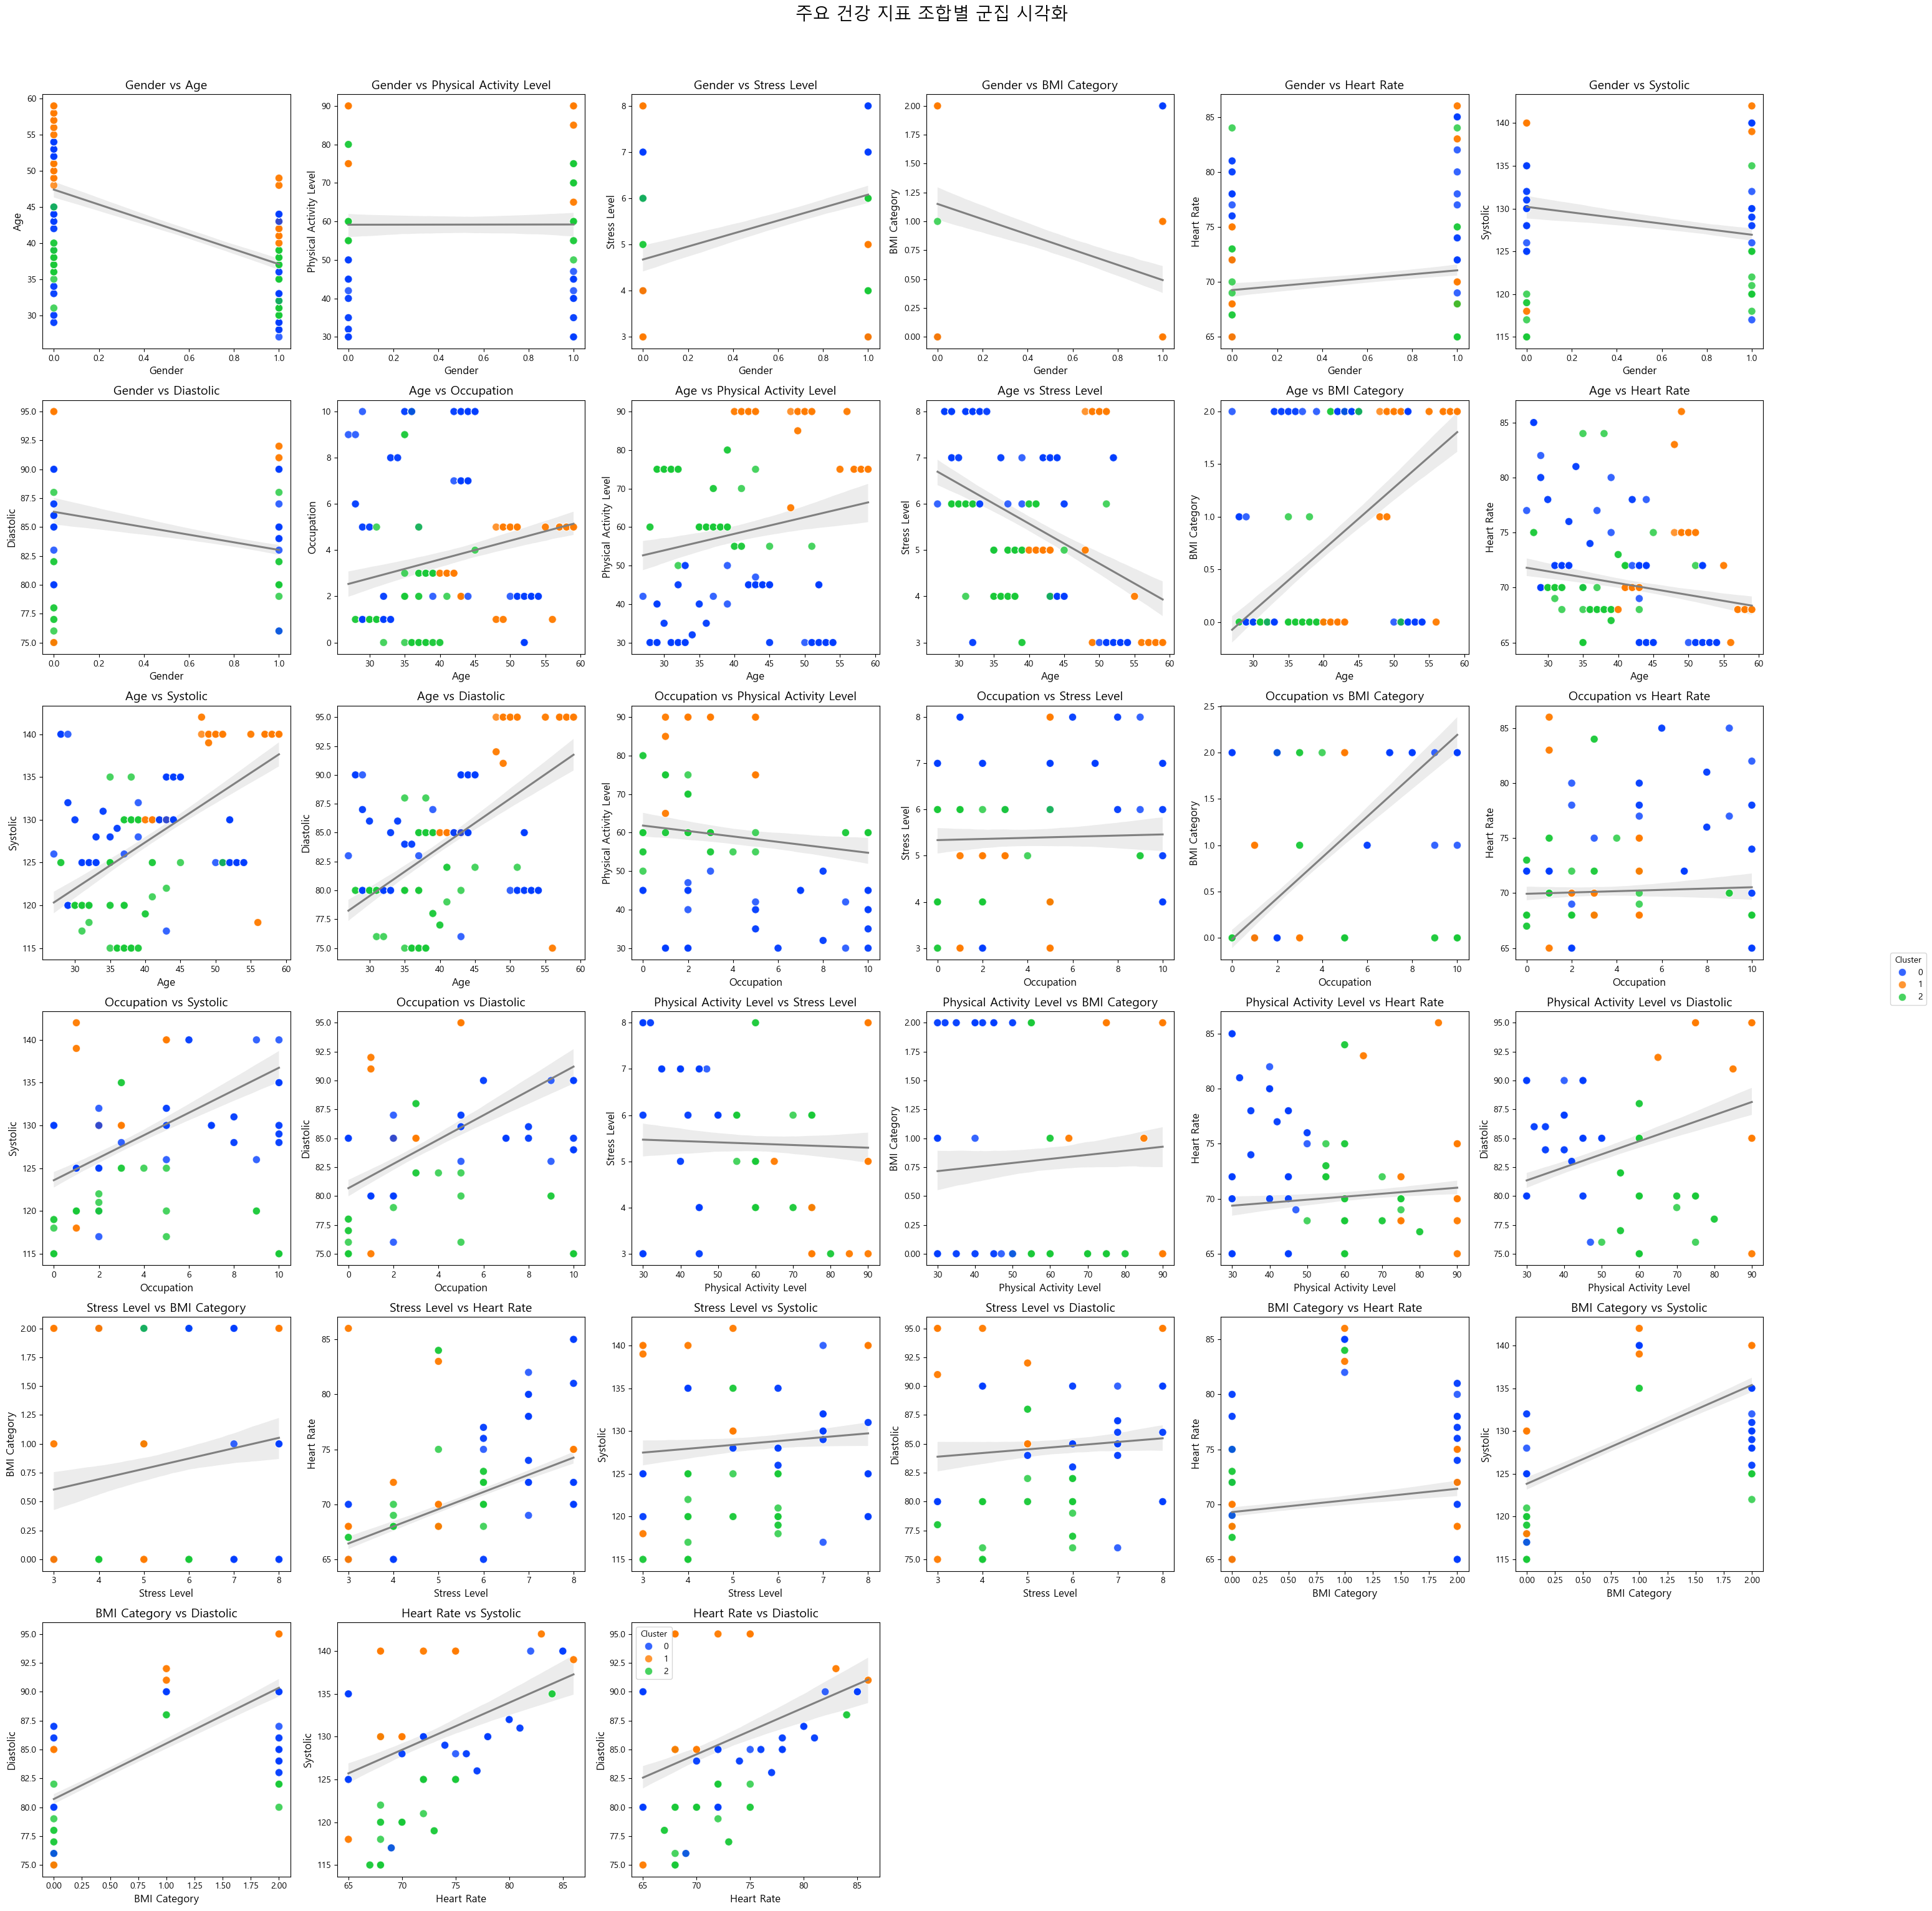

In [29]:

plot_pairs = [
    ('Gender', 'Age'),
    ('Gender', 'Physical Activity Level'),
    ('Gender', 'Stress Level'),
    ('Gender', 'BMI Category'),
    ('Gender', 'Heart Rate'),
    ('Gender', 'Systolic'),
    ('Gender', 'Diastolic'),
    ('Age', 'Occupation'),
    ('Age', 'Physical Activity Level'),
    ('Age', 'Stress Level'),
    ('Age', 'BMI Category'),
    ('Age', 'Heart Rate'),
    ('Age', 'Systolic'),
    ('Age', 'Diastolic'),
    ('Occupation', 'Physical Activity Level'),
    ('Occupation', 'Stress Level'),
    ('Occupation', 'BMI Category'),
    ('Occupation', 'Heart Rate'),
    ('Occupation', 'Systolic'),
    ('Occupation', 'Diastolic'),
    ('Physical Activity Level', 'Stress Level'),
    ('Physical Activity Level', 'BMI Category'),
    ('Physical Activity Level', 'Heart Rate'),
    ('Physical Activity Level', 'Diastolic'),
    ('Stress Level', 'BMI Category'),
    ('Stress Level', 'Heart Rate'),
    ('Stress Level', 'Systolic'),
    ('Stress Level', 'Diastolic'),
    ('BMI Category', 'Heart Rate'),
    ('BMI Category', 'Systolic'),
    ('BMI Category', 'Diastolic'),
    ('Heart Rate', 'Systolic'),
    ('Heart Rate', 'Diastolic'),
]

num_plots = len(plot_pairs)
cols = 6
rows = (num_plots + cols - 1) // cols  # 올림 처리

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
fig.suptitle('주요 건강 지표 조합별 군집 시각화', fontsize=20, y=1.02)

for i, pair in enumerate(plot_pairs):
    r = i // cols
    c = i % cols
    ax = axes[r, c]
    x_feat, y_feat = pair

    if X_cluster[x_feat].dtype.name in ['object', 'category']:
        sns.stripplot(x=x_feat, y=y_feat, data=X_cluster, hue='Cluster', ax=ax,
                      jitter=True, dodge=True, palette='bright', s=8)
    else:
        sns.regplot(x=x_feat, y=y_feat, data=X_cluster, ax=ax, scatter=False, color='gray')
        sns.scatterplot(x=x_feat, y=y_feat, data=X_cluster, hue='Cluster', ax=ax,
                        palette='bright', s=80, alpha=0.8)

    ax.set_title(f'{x_feat} vs {y_feat}', fontsize=14)
    ax.set_xlabel(x_feat, fontsize=12)
    ax.set_ylabel(y_feat, fontsize=12)

    leg = ax.get_legend()
    if leg is not None and i != num_plots - 1:
        leg.remove()

# 남는 subplot 없애기 (옵션)
for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Cluster', bbox_to_anchor=(1.01, 0.5), loc='center left')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


In [30]:
print(X_cluster.columns)

Index(['Gender', 'Age', 'Occupation', 'Physical Activity Level',
       'Stress Level', 'BMI Category', 'Heart Rate', 'Systolic', 'Diastolic',
       'Cluster'],
      dtype='object')


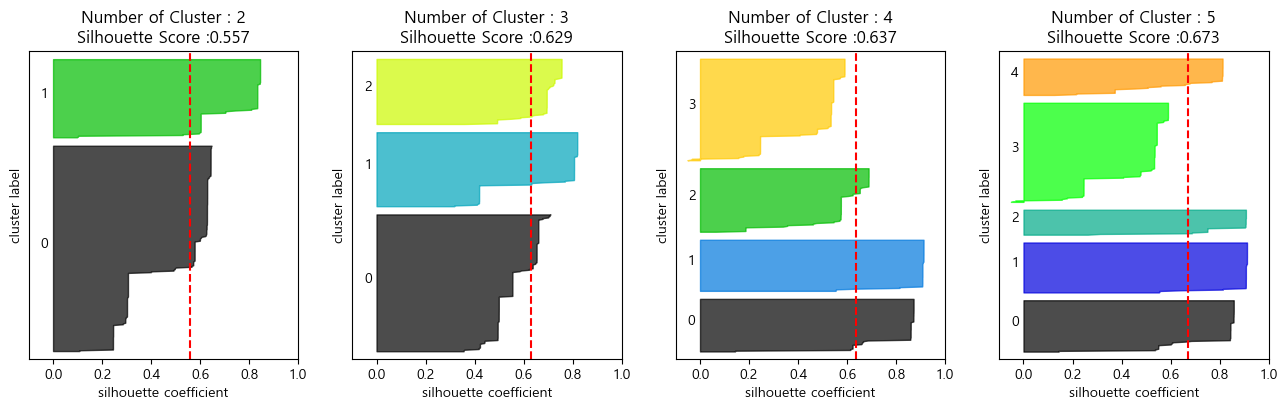

In [31]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def my_chart(cluster_lists, X): 
    
    fig, axs = plt.subplots(figsize=(4*len(cluster_lists), 4), 
                            nrows=1, 
                            ncols=len(cluster_lists))

    for ind, k in enumerate(cluster_lists):
        
        kmeans = KMeans(n_clusters=k, max_iter=500, random_state=1111) 
        cluster_labels = kmeans.fit_predict(X)
        
        sil_coef_mean = silhouette_score(X, cluster_labels)
        sil_coef      = silhouette_samples(X, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(k)+'\n' \
                          'Silhouette Score :' + str(round(sil_coef_mean,3)) )

        axs[ind].set_xlabel("silhouette coefficient")
        axs[ind].set_ylabel("cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X) + (k + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 막대 그래프
        for i in range(k):
            ith_cluster_sil_coef = sil_coef[cluster_labels==i]
            ith_cluster_sil_coef.sort()

            size_cluster_i = ith_cluster_sil_coef.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_coef, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_coef_mean, color="red", linestyle="--")

# 호출할 때
my_chart([2,3,4,5], X)


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# --- 1. 데이터 준비 ---
# X_final: 군집화에 사용한 전처리 완료된 데이터 (예: 스케일링된 데이터)
# df_clean: 원본(전처리 전) 데이터, 해석용으로 사용

# (예시) X_final, df_clean이 이미 준비되어 있다고 가정
# 만약 다르면, 아래 부분에 맞게 수정 필요

print(f"X_final 행개수: {len(X_final)}, df_clean 행개수: {len(df_clean)}")

# --- 2. k=3 군집화 ---
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_final)

# --- 3. 군집 라벨 할당 ---
# df_clean과 X_final 행 인덱스 맞춰 필터링 (필요시)
df_analysis = df_clean.loc[X_final.index].copy()  # 인덱스 일치시키기
df_analysis['Cluster'] = cluster_labels           # 군집 라벨 할당

# --- 4. 군집별 수치형 변수 평균 비교 ---
print(f"--- k={k} 군집별 수치형 변수 평균 비교 ---")
numeric_summary = df_analysis.groupby('Cluster').mean(numeric_only=True).T
display(numeric_summary)

# --- 5. 군집별 범주형 변수 분포 비교 ---
categorical_features = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

print(f"\n--- k={k} 군집별 범주형 변수 분포 ---")
for col in categorical_features:
    print(f"\n{col} 분포")
    display(pd.crosstab(df_analysis['Cluster'], df_analysis[col]))

# --- 6. 군집별 특성 시각화 ---
features_to_visualize = [
    'Stress Level', 'Physical Activity Level', 'Systolic', 'BMI Category', 'Occupation', 'Quality of Sleep'
]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('군집별 주요 특성 비교', fontsize=18)

for i, feature in enumerate(features_to_visualize):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    if df_analysis[feature].nunique() > 5:
        # 수치형 변수: boxplot
        sns.boxplot(x='Cluster', y=feature, data=df_analysis, ax=ax, palette='pastel')
        ax.set_title(f'군집별 {feature} 분포 (Boxplot)', fontsize=13)
    else:
        # 범주형 변수: countplot
        sns.countplot(x=feature, hue='Cluster', data=df_analysis, ax=ax, palette='pastel')
        ax.set_title(f'군집별 {feature} 분포 (Countplot)', fontsize=13)
        if feature == 'Occupation':
            ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

NameError: name 'X_final' is not defined